In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import csv

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [161]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [162]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

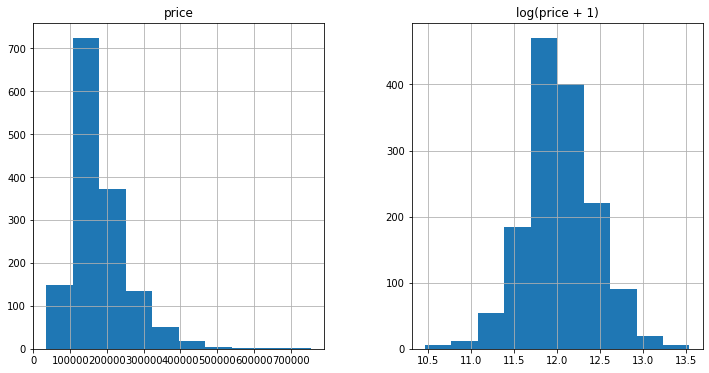

In [163]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [164]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [165]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = rmse_cv(Ridge(alpha = 0.1))


In [166]:
model_ridge.fit(X_train, y)
preds = np.expm1(model_ridge.predict(X_test))
print(test.iloc[:, 0])

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64


In [167]:
header = ['Id', 'SalePrice']
with open('output/prediction.csv', 'w', ) as myfile:
    wr = csv.writer(myfile)
    wr.writerow(header)
    for i in range(preds.size):
        wr.writerow([test.iloc[i, 0], preds[i]])
print("rmse = 0.13043")
    

rmse = 0.13043


In [168]:
cv_ridge = rmse_cv(Ridge(alpha = 10)).mean()
print("Lowest RMSE with single ridge :")
print(cv_ridge)
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("Lowest RMSE with single lasso :")
rmse_cv(model_lasso).mean()

Lowest RMSE with single ridge :
0.12733734668670751
Lowest RMSE with single lasso :


0.1225673588504814

<AxesSubplot:title={'center':'l0 norm with varying alpha'}>

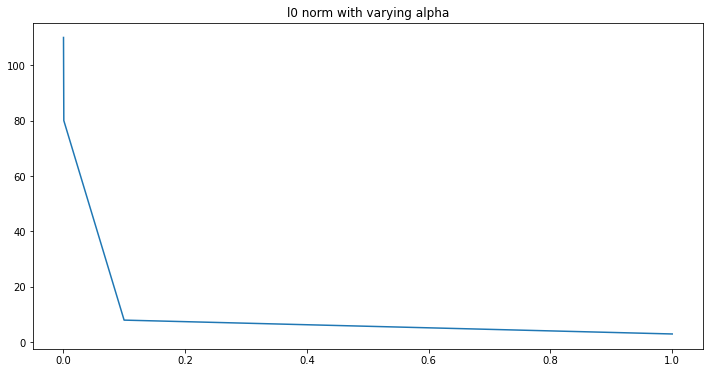

In [169]:
alphas = [1, 0.1, 0.001, 0.0005]
l0 = []
for e in alphas:
    model_lasso_single = Lasso(alpha = e).fit(X_train, y)
    coef = pd.Series(model_lasso_single.coef_, index = X_train.columns)
    l0.append(sum(coef != 0))
l0 = pd.Series(l0, index = alphas)
l0.plot(title = "l0 norm with varying alpha")

In [174]:
# Ensembling and Stacking
preds = np.expm1(model_ridge.predict(X_train))
preds = np.reshape(preds, (-1, 1))
temp = np.append(X_train, preds, 1)
preds = np.expm1(model_lasso.predict(X_train))
preds = np.reshape(preds, (-1, 1))
X_train = np.append(temp, preds, 1)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
print(cv_ridge)
print("rmse is at minimum when alpha = 50")

0.05     0.134908
0.10     0.133475
0.30     0.130137
1.00     0.125256
3.00     0.120531
5.00     0.118555
10.00    0.116315
15.00    0.115313
30.00    0.114235
50.00    0.113973
75.00    0.114078
dtype: float64
rmse is at minimum when alpha = 50


In [198]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor


model_ridge = Ridge(alpha = 50)
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005])
X_train_xgb = all_data[:train.shape[0]]

dtrain = xgb.DMatrix(X_train_xgb, label=y)
dtest = xgb.DMatrix(X_test)
param = {'max_depth':8, 'eta': 0.2, 'min_child_weight': 3, 'objective':'reg:squarederror' }
num_round = 200
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtrain)
print(preds)
print(y)
rms = mean_squared_error(y, preds, squared=False)
print(rms)
preds = np.expm1(bst.predict(dtest))

# xgbr = xgb.XGBRegressor()

# stack = StackingCVRegressor(regressors=(model_ridge, model_lasso, xgbr),
#                             meta_regressor=xgbr,
#                             use_features_in_secondary=False,
#                             store_train_meta_features=True,
#                             shuffle=False,
#                             random_state=42)

# stack.fit(X_train, y)
# preds = stack.predict(X_test)
# print(y)
# print(preds)
# rms = mean_squared_error(y, preds, squared=False)
# print(rms)



In [ ]:
model_ridge.fit(X_train, y)
preds = model_ridge.predict(X_test)

with open('output/submission.csv', 'w', ) as myfile:
    wr = csv.writer(myfile)
    wr.writerow(header)
    for i in range(preds.size):
        wr.writerow([test.iloc[i, 0], np.expm1(preds[i])])